In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import seaborn as sns
from scipy.ndimage import center_of_mass
import pandas as pd

from pathlib import Path
import random
import math
from copy import deepcopy
import shutil
from collections import defaultdict
from tqdm.notebook import tqdm

from src.visualise.plot import plot_data, plot_data_simple
from src.data.paths import project_dir
from src.data.analysis import Circle, create_circular_mask, read_tiff_img
from src.data.detector import find_circle_hough_method, img_for_circle_detection, DetectorDataCollection, DetectorData, DetectorImage

# Data structures

In [2]:
# local paths
# base_path = project_dir / 'data' / 'raw'
# raw_path = base_path / '2024-09-18'
# bg_path = base_path / '2024-09-16'

# # onedrive paths
base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'
# raw_path = base_path / '2024-09-18'
# bg_path = base_path / '2024-09-16'
base_path.exists()

True

In [3]:
data_path = Path(r"C:\Users\Legion\OneDrive - ifj.edu.pl\Projects\MB_foils\publication_Measurement_2024\analysis\interim\2024-11-21\protons\mean_values.h5")
df = pd.read_hdf(data_path, key='data')

In [4]:
df

,det_no,mean_signal,std_signal,radiation,perc_error,dose_Co60_Gy
22,1,276.701835,43.344176,Co60,15.664579,19.721386
23,2,284.830597,42.431502,Co60,14.897101,20.300748
24,3,274.143369,40.490796,Co60,14.769935,19.539036
25,4,281.752133,40.782512,Co60,14.474606,20.081336
26,5,289.250322,43.836095,Co60,15.155072,20.615755
27,6,281.608965,41.215332,Co60,14.635661,20.071132
28,7,287.737727,41.130563,Co60,14.294463,20.507948
29,8,278.174151,41.069129,Co60,14.763819,19.826322
30,9,275.473201,40.981130,Co60,14.876631,19.633817
16,10,277.971149,40.190516,Co60,14.458521,19.811854


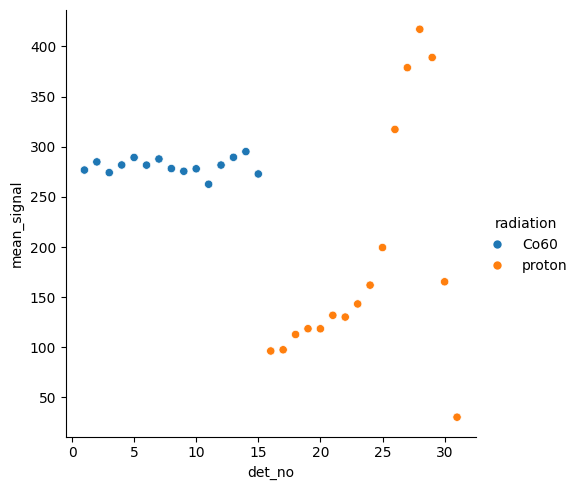

In [5]:
sns.relplot(data=df, x='det_no', y='mean_signal', hue='radiation', kind='scatter')

In [6]:
df

,det_no,mean_signal,std_signal,radiation,perc_error,dose_Co60_Gy
22,1,276.701835,43.344176,Co60,15.664579,19.721386
23,2,284.830597,42.431502,Co60,14.897101,20.300748
24,3,274.143369,40.490796,Co60,14.769935,19.539036
25,4,281.752133,40.782512,Co60,14.474606,20.081336
26,5,289.250322,43.836095,Co60,15.155072,20.615755
27,6,281.608965,41.215332,Co60,14.635661,20.071132
28,7,287.737727,41.130563,Co60,14.294463,20.507948
29,8,278.174151,41.069129,Co60,14.763819,19.826322
30,9,275.473201,40.981130,Co60,14.876631,19.633817
16,10,277.971149,40.190516,Co60,14.458521,19.811854


# Bragg peak data from dosimetry and MC

In [7]:
article_plots_path = Path(r"C:\Users\Legion\OneDrive - ifj.edu.pl\Projects\MB_foils\publication_Measurement_2024\data_for_plots\article-plots.h5")
df_bp_exp = pd.read_hdf(article_plots_path, key='bp_exp')
df_bp_mc = pd.read_hdf(article_plots_path, key='bp_mc')

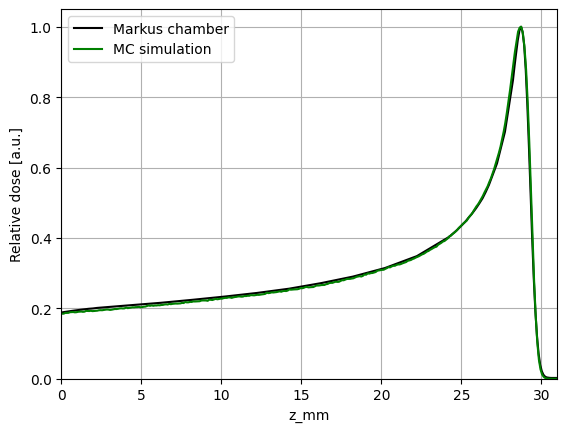

In [8]:
fig, ax = plt.subplots(nrows=1, sharex=True)
df_bp_exp.plot(ax=ax, x='Depth', y='Signal', label='Markus chamber', color='black', style='-')
df_bp_mc.plot(ax=ax, x='z_mm', y='dose', label='MC simulation', color='green', style='-')
ax.set_ylim(0,1.05)
ax.set_xlim(0, 31)
ax.grid()
ax.set_ylabel("Relative dose [a.u.]");

# Detector positions

In [9]:
det_pos_path = Path(r"C:\Users\Legion\OneDrive - ifj.edu.pl\Projects\MB_foils\2024-11-21\fantom_MBO.xlsx")
det_pos = pd.read_excel(
    det_pos_path,
    sheet_name='PB_MBO_20.11.2024',
    skiprows=5, 
    nrows=36, 
    usecols="A,C,E,G",
    names=["det_no", "det_type", "thickness_mm", "pos_center_mm"]
    )
det_pos = det_pos.query("det_type == 'folia MBO'").copy()
det_pos.reset_index(drop=True, inplace=True)
det_pos['det_no'] = det_pos['det_no'].astype(int)
det_pos

,det_no,det_type,thickness_mm,pos_center_mm
0,16,folia MBO,0.4410,3.20350
1,17,folia MBO,0.4305,5.81615
2,18,folia MBO,0.4515,8.43455
3,19,folia MBO,0.4620,11.06870
4,20,folia MBO,0.4620,13.70810
5,21,folia MBO,0.4410,16.31420
6,22,folia MBO,0.4620,18.89750
7,23,folia MBO,0.4515,21.52025
8,24,folia MBO,0.4305,24.11585
9,25,folia MBO,0.4515,26.70689


In [10]:
df_with_pos = det_pos.join(df.set_index('det_no'), on='det_no').copy()
df_with_pos

,det_no,det_type,thickness_mm,pos_center_mm,mean_signal,std_signal,radiation,perc_error,dose_Co60_Gy
0,16,folia MBO,0.4410,3.20350,96.237470,26.863022,proton,27.913267,6.859139
1,17,folia MBO,0.4305,5.81615,97.445035,26.395873,proton,27.087961,6.945206
2,18,folia MBO,0.4515,8.43455,112.685442,27.956868,proton,24.809654,8.031436
3,19,folia MBO,0.4620,11.06870,118.473561,28.754053,proton,24.270438,8.443973
4,20,folia MBO,0.4620,13.70810,118.399992,28.807776,proton,24.330894,8.438729
5,21,folia MBO,0.4410,16.31420,131.834630,30.432680,proton,23.083980,9.396257
6,22,folia MBO,0.4620,18.89750,130.068481,29.785550,proton,22.899898,9.270378
7,23,folia MBO,0.4515,21.52025,143.157623,31.930684,proton,22.304564,10.203282
8,24,folia MBO,0.4305,24.11585,161.919309,34.351362,proton,21.215112,11.540484
9,25,folia MBO,0.4515,26.70689,199.421006,60.253267,proton,30.214102,14.213345


Text(0, 0.5, 'Dose [Gy]')

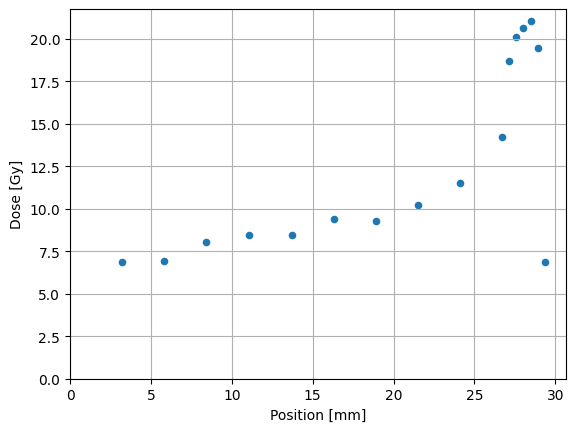

In [11]:
fig, ax = plt.subplots(nrows=1, sharex=True)
df_with_pos.plot(x='pos_center_mm', y='dose_Co60_Gy', kind='scatter', ax = ax)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.grid()
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Dose [Gy]")

# Combining with MC

In [12]:
# create spline interpolator object from scipy for x = df_bp_mc.z_mm and y = df_bp_mc.dose
from scipy.interpolate import interp1d
f = interp1d(df_bp_mc.z_mm, df_bp_mc.dose, kind='cubic')

In [13]:
df_with_pos['dose_interp'] = f(df_with_pos['pos_center_mm'])
df_with_pos['dose_interp'] /= df_with_pos['dose_interp'].iloc[0]
df_with_pos['dose_interp'] *= 7
df_with_pos

,det_no,det_type,thickness_mm,pos_center_mm,mean_signal,std_signal,radiation,perc_error,dose_Co60_Gy,dose_interp
0,16,folia MBO,0.4410,3.20350,96.237470,26.863022,proton,27.913267,6.859139,7.000000
1,17,folia MBO,0.4305,5.81615,97.445035,26.395873,proton,27.087961,6.945206,7.395295
2,18,folia MBO,0.4515,8.43455,112.685442,27.956868,proton,24.809654,8.031436,7.816454
3,19,folia MBO,0.4620,11.06870,118.473561,28.754053,proton,24.270438,8.443973,8.322209
4,20,folia MBO,0.4620,13.70810,118.399992,28.807776,proton,24.330894,8.438729,8.806812
5,21,folia MBO,0.4410,16.31420,131.834630,30.432680,proton,23.083980,9.396257,9.476118
6,22,folia MBO,0.4620,18.89750,130.068481,29.785550,proton,22.899898,9.270378,10.482312
7,23,folia MBO,0.4515,21.52025,143.157623,31.930684,proton,22.304564,10.203282,11.774287
8,24,folia MBO,0.4305,24.11585,161.919309,34.351362,proton,21.215112,11.540484,14.131868
9,25,folia MBO,0.4515,26.70689,199.421006,60.253267,proton,30.214102,14.213345,19.703962


Text(0, 0.5, 'Dose [Gy]')

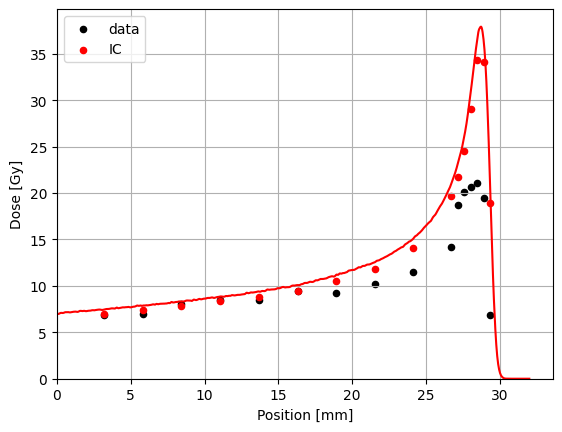

In [14]:
fig, ax = plt.subplots(nrows=1, sharex=True)
x_mm = np.linspace(0.05, 32, 1000)
dose_IC_Gy = f(x_mm) * 7 / f(df_bp_mc.z_mm.iloc[0])
df_with_pos.plot(x='pos_center_mm', y='dose_Co60_Gy', kind='scatter', ax = ax, color='black', label='data')
df_with_pos.plot(x='pos_center_mm', y='dose_interp', kind='scatter', ax = ax, color='red', label='IC')
ax.plot(x_mm, dose_IC_Gy, color='red')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.grid()
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Dose [Gy]")

In [15]:
df_with_pos['efficiency'] = df_with_pos['dose_Co60_Gy'] / df_with_pos['dose_interp']
df_with_pos

,det_no,det_type,thickness_mm,pos_center_mm,mean_signal,std_signal,radiation,perc_error,dose_Co60_Gy,dose_interp,efficiency
0,16,folia MBO,0.4410,3.20350,96.237470,26.863022,proton,27.913267,6.859139,7.000000,0.979877
1,17,folia MBO,0.4305,5.81615,97.445035,26.395873,proton,27.087961,6.945206,7.395295,0.939138
2,18,folia MBO,0.4515,8.43455,112.685442,27.956868,proton,24.809654,8.031436,7.816454,1.027504
3,19,folia MBO,0.4620,11.06870,118.473561,28.754053,proton,24.270438,8.443973,8.322209,1.014631
4,20,folia MBO,0.4620,13.70810,118.399992,28.807776,proton,24.330894,8.438729,8.806812,0.958205
5,21,folia MBO,0.4410,16.31420,131.834630,30.432680,proton,23.083980,9.396257,9.476118,0.991572
6,22,folia MBO,0.4620,18.89750,130.068481,29.785550,proton,22.899898,9.270378,10.482312,0.884383
7,23,folia MBO,0.4515,21.52025,143.157623,31.930684,proton,22.304564,10.203282,11.774287,0.866573
8,24,folia MBO,0.4305,24.11585,161.919309,34.351362,proton,21.215112,11.540484,14.131868,0.816628
9,25,folia MBO,0.4515,26.70689,199.421006,60.253267,proton,30.214102,14.213345,19.703962,0.721345


Text(0, 0.5, 'Dose [Gy]')

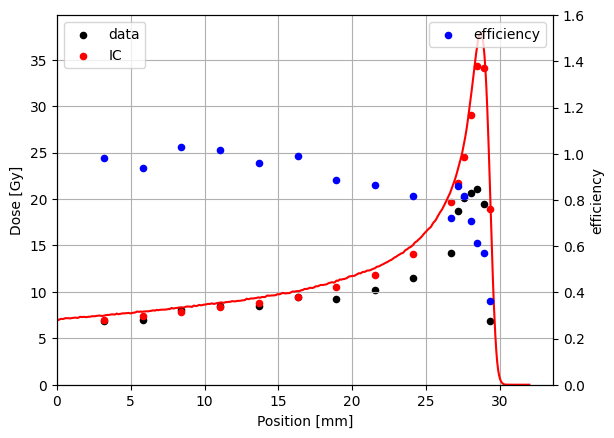

In [16]:
fig, ax = plt.subplots(nrows=1, sharex=True)
x_mm = np.linspace(0.05, 32, 1000)
dose_IC_Gy = f(x_mm) * 7 / f(df_bp_mc.z_mm.iloc[0])
df_with_pos.plot(x='pos_center_mm', y='dose_Co60_Gy', kind='scatter', ax = ax, color='black', label='data')
df_with_pos.plot(x='pos_center_mm', y='dose_interp', kind='scatter', ax = ax, color='red', label='IC')
ax_right = ax.twinx()
ax_right.set_ylabel("Efficiency")
ax_right.set_ylim(0, 1.6)
df_with_pos.plot(x='pos_center_mm', y='efficiency', kind='scatter', ax = ax_right, color='blue', label='efficiency')
ax.plot(x_mm, dose_IC_Gy, color='red')
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.grid()
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Dose [Gy]")